# Librerie, set GPU e import dati

In [1]:
import matplotlib
import glob
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.ops import math_ops
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose, UpSampling2D, SeparableConv2D
from tensorflow.keras.layers import ZeroPadding2D,Add,ReLU,AveragePooling2D
from tensorflow.keras import metrics as mtt
from tensorflow.keras import optimizers

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8*1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

Create the list of existing scans with a segmentation

In [3]:
fileL = glob.glob('dati_orig/*/*/truth.nii.gz')
print(len(fileL))
iHead = nib.load(fileL[0])

167


Set how many patients we want to analyze, and using which images

In [4]:
nPatAn = 60   # numero di pazienti
nChan=4   # numero di canali da analizzare
chanNames = {1:'t1.nii.gz',2:'t1ce.nii.gz',3:'flair.nii.gz',0:'t2.nii.gz'}   # nomi dei canali

In [5]:
for chanL in chanNames.keys():
    print(chanNames[chanL])

t1.nii.gz
t1ce.nii.gz
flair.nii.gz
t2.nii.gz


### Impostare i dati

Si analizzano solo alcuni pazienti, per questione di memoria: sottocampioniamo le immagini in dimensioni 2x2x2 mm!

In [6]:
immV = np.zeros((nPatAn,120,120,77,nChan),dtype=np.float32)
segV = np.zeros((nPatAn,120,120,77,1),dtype=np.float32)

In [8]:
for pIdx,fN in enumerate(fileL[:nPatAn]):
    pDir = os.path.dirname(fN)
    for chanL in chanNames.keys():
        iHead = nib.load(os.path.join(pDir,chanNames[chanL]))
        iTemp = iHead.get_fdata(dtype=np.float32)
        iTemp = iTemp[:,:,1:].reshape((2,120,2,120,2,77),order='F')
        immV[pIdx,:,:,:,chanL]= np.mean(np.mean(np.mean(iTemp,axis=-2),axis=-3),axis=0)
    iHead = nib.load(fN)
    iTemp = iHead.get_fdata(dtype=np.float32)
    iTemp = iTemp[:,:,1:].reshape((2,120,2,120,2,77),order='F')
    segV[pIdx,:,:,:,0]= np.max(np.max(np.max(iTemp,axis=-2),axis=-3),axis=0)

### Image scaling

Immagini scalate, per avere l'intensità media (miglior training)

In [9]:
intVal = np.zeros((immV.shape[0],nChan),dtype=np.float32)
for sub in range(immV.shape[0]):
  for chan in range(nChan):
    iTemp = np.squeeze(immV[sub,:,:,:,chan])
    lThr = np.percentile(iTemp,1)
    intVal[sub,chan]=np.percentile(iTemp[iTemp>lThr],50)
intVal = intVal.reshape((immV.shape[0],1,1,1,nChan))
immV = (immV-0.5*intVal)/intVal
segV[segV>3.5]=3
segV = tf.keras.utils.to_categorical(segV)

### Da 3D a 2D

Prima divisione in dataset di training e di test, poi vengono create le "fette" 2D dalle immagini 3D

In [71]:
X_train, X_test, y_train, y_test = train_test_split(immV, segV, test_size=0.33, random_state=42)  # 2/3 training, 1/3 test

In [72]:
X_train = X_train.transpose((0,3,1,2,4))
X_train = X_train.reshape((-1,120,120,4))
y_train = y_train.transpose((0,3,1,2,4))
y_train = y_train.reshape((-1,120,120,4))

X_test = X_test.transpose((0,3,1,2,4))
X_test = X_test.reshape((-1,120,120,4))
y_test = y_test.transpose((0,3,1,2,4))
y_test = y_test.reshape((-1,120,120,4))

In [73]:
print(y_train.shape)

(3080, 120, 120, 4)


# U-NET

Creazione di una U-NET semplice.

In [18]:
inputL = Input([immV.shape[1],immV.shape[2],nChan])

## Encoder section
 
c1 = Conv2D(16,3,activation='relu',padding='same') (inputL) # 120x120
c2 = Conv2D(16,3,activation='relu',padding='same') (c1)

c3 = MaxPooling2D() (c2) # 60x60
c4 = Conv2D(32,3,activation='relu',padding='same') (c3)
c5 = Conv2D(32,3,activation='relu',padding='same') (c4)

c6 = MaxPooling2D() (c5) #30x30
c7 = Conv2D(64,3,activation='relu',padding='same') (c6)
c8 = Conv2D(64,3,activation='relu',padding='same') (c7)

c9 = MaxPooling2D() (c8) #15x15
## Bridge

c10 = Conv2D(128,3,activation='relu',padding='same') (c9)
c11 = Conv2D(128,3,activation='relu',padding='same') (c10)
c12 = Conv2D(128,3,activation='relu',padding='same') (c11)
c13 = UpSampling2D() (c12) #30x30

## "Decoder" network

c14 = concatenate([c13,c8])
c15 = Conv2D(64,3,activation='relu',padding='same') (c14)
c16 = Conv2D(64,3,activation='relu',padding='same') (c15)

c17 = UpSampling2D() (c16) #60x60
c18 = concatenate([c17,c5])
c19 = Conv2D(32,3,activation='relu',padding='same') (c18)
c20 = Conv2D(32,3,activation='relu',padding='same') (c19)

c21 = UpSampling2D() (c20) #120x120
c22 = concatenate([c21,c2])
c23 = Conv2D(16,3,activation='relu',padding='same') (c22)
c24 = Conv2D(16,3,activation='relu',padding='same') (c23)

# Output layer. 4 classi come output (0: sfondo e i 3 tipi di tumore)

outL = Conv2D(4,3,activation='softmax',padding='same')(c24)
model = Model(inputs=inputL,outputs=outL)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 120, 120, 16)         592       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 120, 120, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 60, 60, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Definizione score di Dice

Calcolo del Dice Score

In [20]:
def dice_accuracy(y_true, y_pred):

  y_true = math_ops.cast(y_true[:,:,:,1:] > 0.5, y_pred.dtype)
  y_pred = math_ops.cast(y_pred[:,:,:,1:] > 0.5, y_pred.dtype)
  intersec = y_true*y_pred
  union = y_true+y_pred
  dicePat = (1+2*K.sum(intersec,axis=[1,2]))/(1+K.sum(union,axis=[1,2]))
  return K.mean(dicePat)

### Define the optimizer and compile the model

In [21]:
optim = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optim,loss='categorical_crossentropy',metrics= [dice_accuracy])

In [53]:
fitHist = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=8,epochs=40)

Epoch 1/40
385/385 [==============================] - 173s 449ms/step - loss: 0.0351 - dice_accuracy: 0.6963 - val_loss: 0.0323 - val_dice_accuracy: 0.6861
Epoch 2/40
385/385 [==============================] - 169s 440ms/step - loss: 0.0228 - dice_accuracy: 0.7179 - val_loss: 0.0314 - val_dice_accuracy: 0.7159
Epoch 3/40
385/385 [==============================] - 170s 441ms/step - loss: 0.0196 - dice_accuracy: 0.7382 - val_loss: 0.0268 - val_dice_accuracy: 0.7203
Epoch 4/40
385/385 [==============================] - 169s 439ms/step - loss: 0.0179 - dice_accuracy: 0.7451 - val_loss: 0.0365 - val_dice_accuracy: 0.7199
Epoch 5/40
385/385 [==============================] - 169s 440ms/step - loss: 0.0164 - dice_accuracy: 0.7497 - val_loss: 0.0302 - val_dice_accuracy: 0.7274
Epoch 6/40
385/385 [==============================] - 169s 439ms/step - loss: 0.0156 - dice_accuracy: 0.7642 - val_loss: 0.0280 - val_dice_accuracy: 0.7589
Epoch 7/40
385/385 [==============================] - 169s 439ms

### Grafico Dice Score 

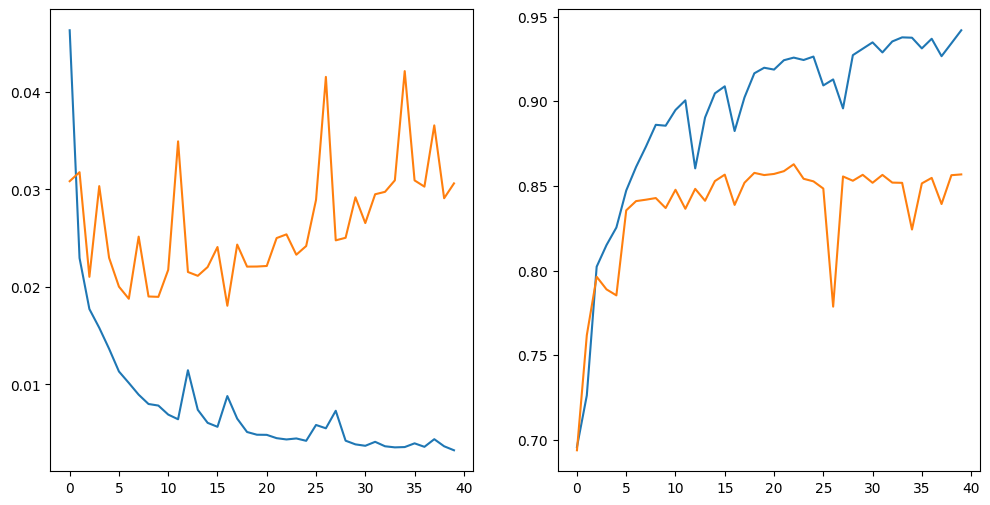

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(fitHist.history['loss'])
plt.plot(fitHist.history['val_loss'])
plt.subplot(122)
plt.plot(fitHist.history['dice_accuracy'])
plt.plot(fitHist.history['val_dice_accuracy'])


### Calcolo DICE scores per le tre categorie:

Tre categorie presenti:
1. Intero tumore (1+2+4)
2. Core tumor (2+4)
3. Active tumor (4)

In [24]:
def diceFromMap(map1,map2):
    unionLab = np.sum(map1) +np.sum(map2)
    interLab = np.sum(map1 & map2, dtype=np.float32)
    return (2*interLab+.1)/(unionLab+.1)
def computeDices (yPred,yTrue):
    yPred = np.asarray(yPred)
    yTrue = np.asarray(yTrue)
    if np.sum(yTrue[:,:,:,1:])<1:
        return(np.nan,np.nan,np.nan)
    diceWhole = diceFromMap(np.sum(yPred[:,:,:,1:],axis=-1)>np.sum(yPred[:,:,:,:1],axis=-1),
                            np.sum(yTrue[:,:,:,1:],axis=-1)>np.sum(yTrue[:,:,:,:1],axis=-1))
    diceCore = diceFromMap(np.sum(yPred[:,:,:,2:],axis=-1)>np.sum(yPred[:,:,:,:2],axis=-1),
                           np.sum(yTrue[:,:,:,2:],axis=-1)>np.sum(yTrue[:,:,:,:2],axis=-1))
    diceEnh = diceFromMap(np.sum(yPred[:,:,:,3:],axis=-1)>np.sum(yPred[:,:,:,:3],axis=-1),
                          np.sum(yTrue[:,:,:,3:],axis=-1)>np.sum(yTrue[:,:,:,:3],axis=-1))
    return (diceWhole,diceCore,diceEnh)

In [25]:
nTestPat = 20
diceV = np.zeros((20,3))
for idx in range(20):
    yPred = model(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

Whole Dice: mean = 83.6% Median = 90.4%
Core Dice: mean = 80.9% Median = 86.6%
Active Dice: mean = 79.0% Median = 83.8%


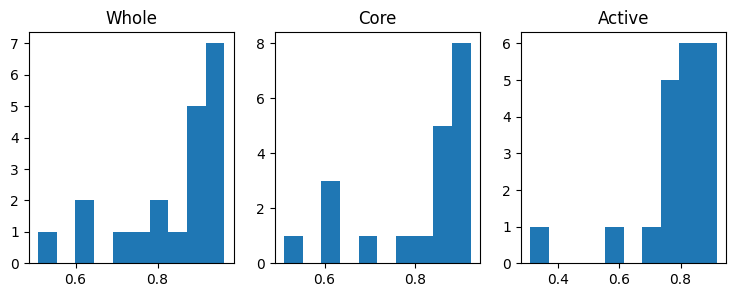

In [26]:
plt.figure(figsize=(9,3))
titleList = ['Whole','Core','Active']
for i in range(3):
    plt.subplot(1,3,i+1)
    _=plt.hist(diceV[:,i])
    plt.title(titleList[i])
for i in range(3):
    outStr = titleList[i] + ' Dice: mean = {:.1f}% Median = {:.1f}%'
    print(outStr.format(np.mean(diceV[:,i]*100),np.median(diceV[:,i]*100)))

# Visualizzare la segmentazione di un singolo paziente

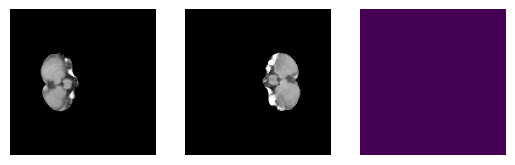

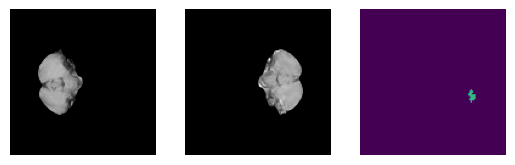

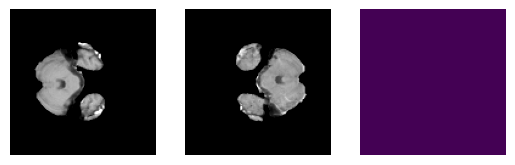

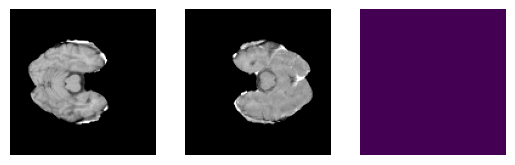

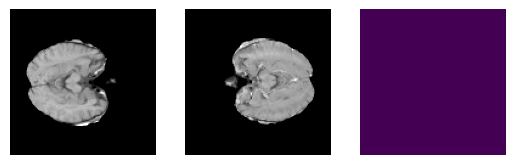

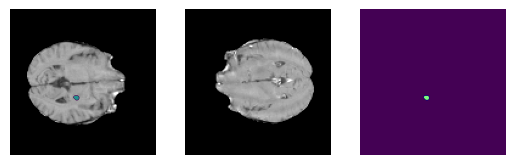

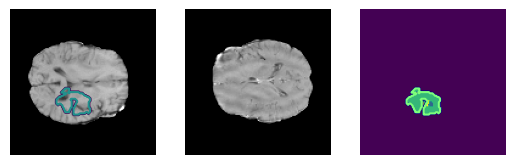

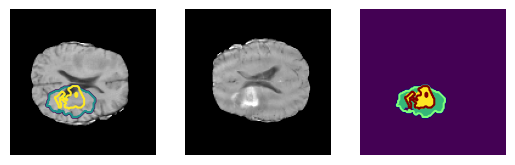

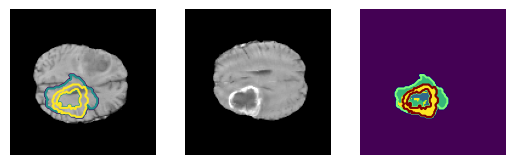

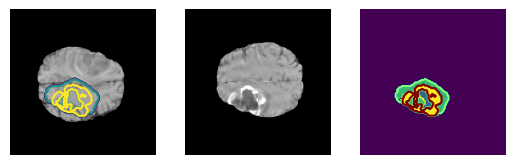

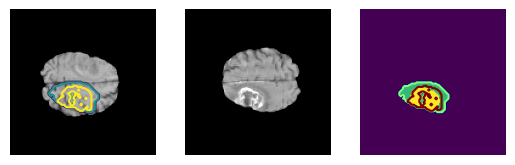

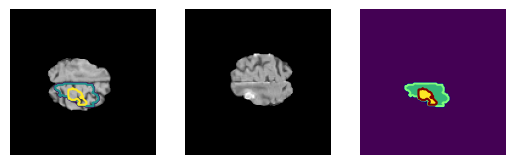

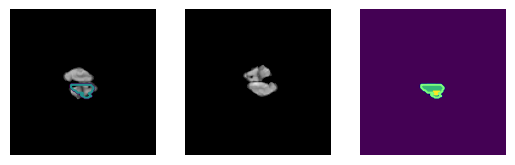

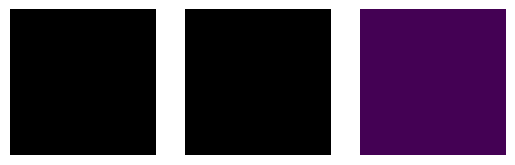

In [27]:
patIdx = 1
slStart = 3
slStop = 70
slStep = 5

yPred = np.array(model(X_test[(patIdx*77):((patIdx+1)*77),:,:,:]))
yPred = np.argmax(yPred,axis=-1)
yTrue = y_test[(patIdx*77):((patIdx+1)*77),:,:,:]
yTrue = np.argmax(yTrue,axis=-1)
for slIdx in range(slStart,slStop,slStep):
    plt.figure()
    plt.subplot(131)
    plt.imshow(np.flip(X_test[patIdx*77+slIdx,:,:,1]),vmin=-0.3,vmax=1.0,cmap='gray')
    plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(X_test[patIdx*77+slIdx,:,:,2],vmin=-0.3,vmax=1.0,cmap='gray')
    plt.axis('off')
  #  plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5])
    plt.subplot(133)
    plt.imshow(yPred[slIdx,:,:],vmin=0,vmax=3)
    plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5],cmap='jet')
    plt.axis('off')

# Possibili miglioramenti

If you have IT resources you can increase the number of training subjects and the networks free parameters.

Nonetheless, some improvements can be already performed in this simple model!
1. Are the 4 classes (including background) equally represented?
2. Can you perform data augmentation?
3. Try another architecture (maybe residual!)
3. You could try building a 3D network instead of individual slices (just use "Conv3D" instead of "Conv2D"). Think about the memory requirements before!!!
4. You could perform reinforcement learning by requiring that the algorithm also recognizes air, gray matter, white matter, CSF
5. You could predict from the "deep" layers information about the volume and the presence of the lesion in each slice (deep supervision)

# Data augmentation con ImageDataGenerator

In [44]:
data_augmentation = ImageDataGenerator(rotation_range=0.2,
                                       rescale=1./255,
                                       zoom_range=0.3, 
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       horizontal_flip=True,
                                       vertical_flip=True)

In [45]:
augmented_train_data = data_augmentation.flow(X_train, y_train, batch_size=8)

In [47]:
fitHist_aug = model.fit(augmented_train_data, validation_data=(X_test, y_test), epochs=40)

Epoch 1/40
385/385 [==============================] - 181s 471ms/step - loss: 0.0731 - dice_accuracy: 0.6925 - val_loss: 0.0793 - val_dice_accuracy: 0.6852
Epoch 2/40
385/385 [==============================] - 178s 462ms/step - loss: 0.0630 - dice_accuracy: 0.6925 - val_loss: 0.0748 - val_dice_accuracy: 0.6852
Epoch 3/40
385/385 [==============================] - 180s 468ms/step - loss: 0.0624 - dice_accuracy: 0.6925 - val_loss: 0.0717 - val_dice_accuracy: 0.6852
Epoch 4/40
385/385 [==============================] - 176s 457ms/step - loss: 0.0768 - dice_accuracy: 0.6863 - val_loss: 0.1286 - val_dice_accuracy: 0.6752
Epoch 5/40
385/385 [==============================] - 182s 473ms/step - loss: 0.0602 - dice_accuracy: 0.6925 - val_loss: 0.1682 - val_dice_accuracy: 0.6533
Epoch 6/40
385/385 [==============================] - 183s 474ms/step - loss: 0.0581 - dice_accuracy: 0.6925 - val_loss: 4.5573 - val_dice_accuracy: 0.6668
Epoch 7/40
385/385 [==============================] - 184s 479ms

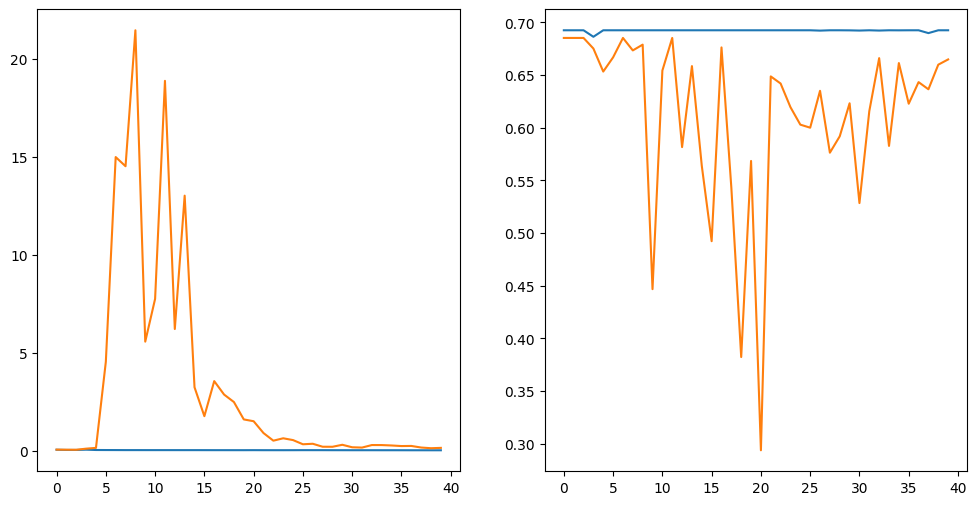

In [48]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(fitHist_aug.history['loss'])
plt.plot(fitHist_aug.history['val_loss'])
plt.subplot(122)
plt.plot(fitHist_aug.history['dice_accuracy'])
plt.plot(fitHist_aug.history['val_dice_accuracy'])

In [50]:
nTestPat = 20
diceV = np.zeros((20,3))
for idx in range(20):
    yPred = model(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

Whole Dice: mean = 0.1% Median = 0.0%
Core Dice: mean = 0.1% Median = 0.0%
Active Dice: mean = 0.0% Median = 0.0%


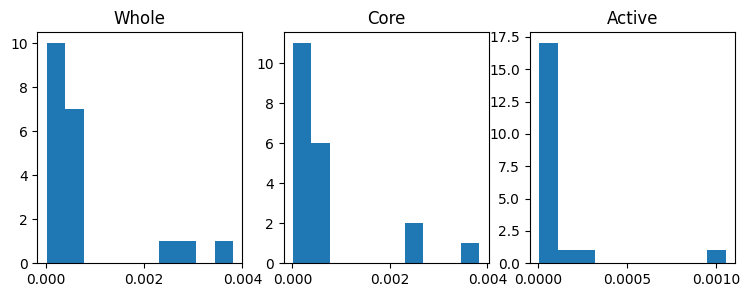

In [51]:
plt.figure(figsize=(9,3))
titleList = ['Whole','Core','Active']
for i in range(3):
    plt.subplot(1,3,i+1)
    _=plt.hist(diceV[:,i])
    plt.title(titleList[i])
for i in range(3):
    outStr = titleList[i] + ' Dice: mean = {:.1f}% Median = {:.1f}%'
    print(outStr.format(np.mean(diceV[:,i]*100),np.median(diceV[:,i]*100)))

# Class Representation 

In [91]:
segV_2 = segV
intVal = np.zeros((immV.shape[0],nChan),dtype=np.float32)
for sub in range(immV.shape[0]):
  for chan in range(nChan):
    iTemp = np.squeeze(immV[sub,:,:,:,chan])
    lThr = np.percentile(iTemp,1)
    intVal[sub,chan]=np.percentile(iTemp[iTemp>lThr],50)
intVal = intVal.reshape((immV.shape[0],1,1,1,nChan))
immV = (immV-0.5*intVal)/intVal
segV_2 = np.clip(segV_2, 0, 3)  # per limitare i valori tra 0 e 3
segV_2 = tf.keras.utils.to_categorical(segV_2, num_classes=4)

In [92]:
X_train_cr, X_test_cr, y_train_cr, y_test_cr = train_test_split(immV, segV_2, test_size=0.33, random_state=42)

In [93]:
X_train_cr = X_train_cr.transpose((0,3,1,2,4))
X_train_cr = X_train_cr.reshape((-1,120,120,4))
y_train_cr = y_train_cr.transpose((0,3,1,2,4))
y_train_cr = y_train_cr.reshape((-1,120,120,4))

X_test_cr = X_test_cr.transpose((0,3,1,2,4))
X_test_cr = X_test_cr.reshape((-1,120,120,4))
y_test_cr = y_test_cr.transpose((0,3,1,2,4))
y_test_cr = y_test_cr.reshape((-1,120,120,4))

In [94]:
inputL = Input([immV.shape[1],immV.shape[2],nChan])
## Encoder section
# 120x120 resolution layers
c1 = Conv2D(16,3,activation='relu',padding='same') (inputL)
c2 = Conv2D(16,3,activation='relu',padding='same') (c1)

c3 = MaxPooling2D() (c2) # 60x60
c4 = Conv2D(32,3,activation='relu',padding='same') (c3)
c5 = Conv2D(32,3,activation='relu',padding='same') (c4)

c6 = MaxPooling2D() (c5) #30x30
c7 = Conv2D(64,3,activation='relu',padding='same') (c6)
c8 = Conv2D(64,3,activation='relu',padding='same') (c7)

c9 = MaxPooling2D() (c8) #15x15
## Bridge
# "low resolution" high abstraction layer
c10 = Conv2D(128,3,activation='relu',padding='same') (c9)
c11 = Conv2D(128,3,activation='relu',padding='same') (c10)
c12 = Conv2D(128,3,activation='relu',padding='same') (c11)
c13 = UpSampling2D() (c12) #30x30

## "Decoder" network
# upsample the output and concatenate it to the encoder layer at the same resolution
c14 = concatenate([c13,c8])
c15 = Conv2D(64,3,activation='relu',padding='same') (c14)
c16 = Conv2D(64,3,activation='relu',padding='same') (c15)

c17 = UpSampling2D() (c16) #60x60
c18 = concatenate([c17,c5])
c19 = Conv2D(32,3,activation='relu',padding='same') (c18)
c20 = Conv2D(32,3,activation='relu',padding='same') (c19)

c21 = UpSampling2D() (c20) #120x120
c22 = concatenate([c21,c2])
c23 = Conv2D(16,3,activation='relu',padding='same') (c22)
c24 = Conv2D(16,3,activation='relu',padding='same') (c23)

# Output layer. We have 4 classes as output (0: background + 3 types of tumor)
# Therefore we use a softmax activation and 4 channels of output
outL = Conv2D(4,3,activation='softmax',padding='same')(c24)
model = Model(inputs=inputL,outputs=outL)

In [96]:
optim = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optim,loss='categorical_crossentropy',metrics= [dice_accuracy])

In [97]:
fitHist_cr = model.fit(X_train_cr,y_train_cr,validation_data=(X_test_cr,y_test_cr),batch_size=8,epochs=40)

Epoch 1/40
385/385 [==============================] - 175s 448ms/step - loss: 0.0532 - dice_accuracy: 0.7048 - val_loss: 0.0296 - val_dice_accuracy: 0.7137
Epoch 2/40
385/385 [==============================] - 172s 447ms/step - loss: 0.0223 - dice_accuracy: 0.7584 - val_loss: 0.0234 - val_dice_accuracy: 0.7705
Epoch 3/40
385/385 [==============================] - 177s 460ms/step - loss: 0.0163 - dice_accuracy: 0.8142 - val_loss: 0.0227 - val_dice_accuracy: 0.8053
Epoch 4/40
385/385 [==============================] - 175s 455ms/step - loss: 0.0138 - dice_accuracy: 0.8359 - val_loss: 0.0251 - val_dice_accuracy: 0.8147
Epoch 5/40
385/385 [==============================] - 170s 441ms/step - loss: 0.0114 - dice_accuracy: 0.8537 - val_loss: 0.0222 - val_dice_accuracy: 0.8269
Epoch 6/40
385/385 [==============================] - 183s 476ms/step - loss: 0.0105 - dice_accuracy: 0.8584 - val_loss: 0.0229 - val_dice_accuracy: 0.8302
Epoch 7/40
385/385 [==============================] - 182s 473ms

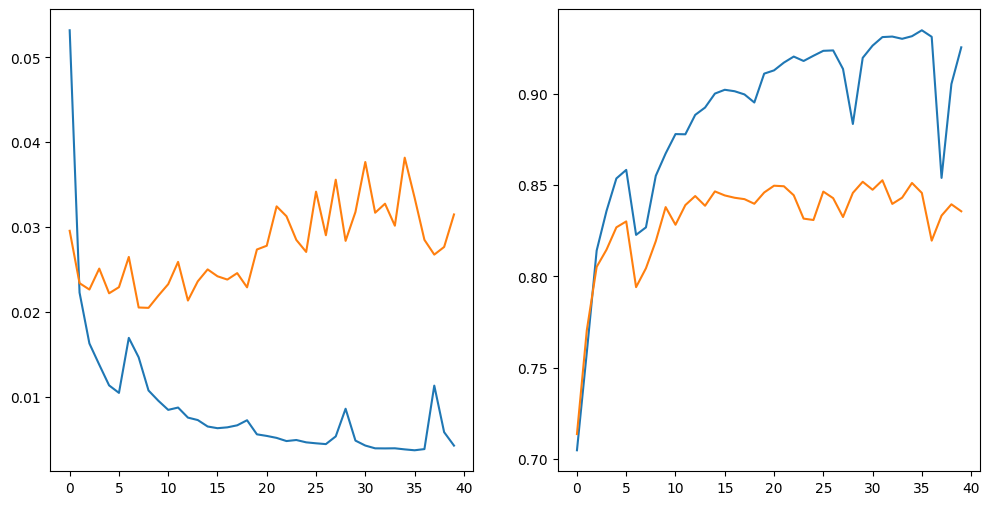

In [98]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(fitHist_cr.history['loss'])
plt.plot(fitHist_cr.history['val_loss'])
plt.subplot(122)
plt.plot(fitHist_cr.history['dice_accuracy'])
plt.plot(fitHist_cr.history['val_dice_accuracy'])

In [101]:
nTestPat = 20
diceV = np.zeros((20,3))
for idx in range(20):
    yPred = model(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV[idx,:]=np.array(computeDices(yPred,y_test_cr[idx*77:(idx+1)*77,:,:,:]))

Whole Dice: mean = 78.8% Median = 86.5%
Core Dice: mean = 75.4% Median = 83.3%
Active Dice: mean = 72.7% Median = 79.4%


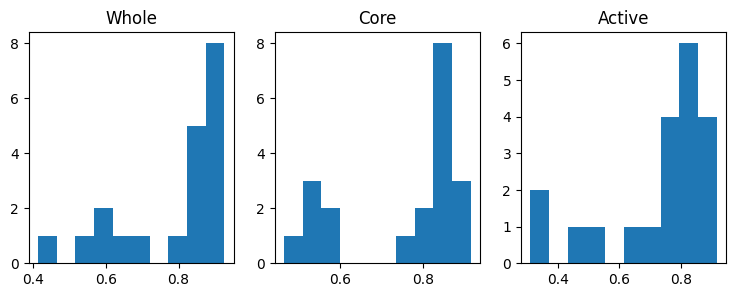

In [102]:
plt.figure(figsize=(9,3))
titleList = ['Whole','Core','Active']
for i in range(3):
    plt.subplot(1,3,i+1)
    _=plt.hist(diceV[:,i])
    plt.title(titleList[i])
for i in range(3):
    outStr = titleList[i] + ' Dice: mean = {:.1f}% Median = {:.1f}%'
    print(outStr.format(np.mean(diceV[:,i]*100),np.median(diceV[:,i]*100)))